In [2]:

import json
import pandas as pd


def read_json_to_dataframe(file_path):
  """Reads the JSON file and convert only the 'results' node into a DataFrame.

  Args:
    file_path: The path to the JSON file.

  Returns:
    A pandas DataFrame containing the data from the 'results' node.
  """

  with open(file_path, 'r') as f:
    data = json.load(f)

  if 'results' in data:
    return pd.DataFrame(data['results'])
  else:
    return pd.DataFrame()  # Return an empty DataFrame if 'results' node is not found.


file_path = 'data/food-enforcement.json'  # Replace with the actual path
df = read_json_to_dataframe(file_path)

df = df.dropna(subset=['classification'])

# drop columns openfda	product_type	event_id

columns_to_drop = ['openfda', 'product_type', 'event_id']

df = df.drop(columns=columns_to_drop, errors='ignore')

#null or yet to be classified are considered outliers
valid_classifications = ['Class I', 'Class II', 'Class III']
df = df[df['classification'].isin(valid_classifications)]

# Convert specified columns to datetime
date_columns = ['recall_initiation_date', 'center_classification_date', 'report_date', 'termination_date']
for col in date_columns:
     df[col] = pd.to_datetime(df[col], errors='coerce')


# Infer data types and convert columns
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], errors='ignore')
    elif pd.api.types.is_datetime64_any_dtype(df[col]):
        continue  # Skip datetime columns
    else:
        # Convert to categorical for object types if cardinality is below a threshold
        if df[col].nunique() / len(df) < 0.5: # Adjust threshold as needed
            df[col] = df[col].astype('category')
        else:
            df[col] = df[col].astype(str) # Convert to strings for other object types

# determine the time taken to recall from the report date
df['lag_days'] = (df['center_classification_date'] - df['recall_initiation_date']).dt.days

# Define keywords and their corresponding categories
keywords = {
    'bacterial': ['contaminated','coli', 'contamination', 'salmonella', 'listeria','presence'],
    'foreign objects': ['metal', 'plastic', 'foreign', 'glass','aluminium','tin','iron'],
    'mislabeled': ['label','declare','misbranded','exceed','specification'],
    'process': ['violation','license', 'inspect','level','process','unsafe','appropriate','infestation'],
    'allergens':['allerg']

}

# Function to classify reasons
def classify_reason(reason):
    reason = str(reason).lower() # Convert reason to lower case for case-insensitive matching
    for category, words in keywords.items():
        for word in words:
          if word.lower() in reason:
              return category
    return 'other'

# Apply the classification function to create a new 'classification' column
df['reason'] = df['reason_for_recall'].apply(classify_reason)


df.to_csv('data/food-enforcement.csv', index=False)
df.info()
df.head()


<ipython-input-2-e183f56ce097>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-2-e183f56ce097>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-2-e183f56ce097>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

<class 'pandas.core.frame.DataFrame'>
Index: 27137 entries, 0 to 27137
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   status                      27137 non-null  category      
 1   city                        27137 non-null  category      
 2   state                       27137 non-null  category      
 3   country                     27137 non-null  category      
 4   classification              27137 non-null  category      
 5   recalling_firm              27137 non-null  category      
 6   address_1                   27137 non-null  category      
 7   address_2                   27137 non-null  category      
 8   postal_code                 27137 non-null  category      
 9   voluntary_mandated          27137 non-null  category      
 10  initial_firm_notification   27137 non-null  category      
 11  distribution_pattern        27137 non-null  category      


,status,city,state,country,classification,recalling_firm,address_1,address_2,postal_code,voluntary_mandated,...,product_quantity,reason_for_recall,recall_initiation_date,center_classification_date,report_date,code_info,more_code_info,termination_date,lag_days,reason
0,Completed,Cicero,IL,United States,Class II,ZB Importing LLC,5400 W 35th St,,60804-4431,Voluntary: Firm initiated,...,433 cases,Milk not declared as the major food allergen s...,2025-02-15,2025-03-13,2025-03-19,L07 04/2025 and L11 EXP 11/2025,,NaT,26.0,mislabeled
1,Ongoing,Walnut Creek,CA,United States,Class II,"Del Monte Foods, Inc",205 N Wiget Ln,,94598-2403,Voluntary: Firm initiated,...,"8,242cases (24cans/case)",Foreign Object,2025-02-12,2025-03-13,2025-03-19,"Best if Used By 28 OCT 2026, Lot 7AA 418507",,NaT,29.0,foreign objects
2,Completed,Cicero,IL,United States,Class II,ZB Importing LLC,5400 W 35th St,,60804-4431,Voluntary: Firm initiated,...,145 cases,Milk not listed in Contains statement,2025-02-15,2025-03-13,2025-03-19,"L09 EXP 04/2025, L11 EXP 05/2025 and L07 EXP 0...",,NaT,26.0,other
3,Completed,Cicero,IL,United States,Class II,ZB Importing LLC,5400 W 35th St,,60804-4431,Voluntary: Firm initiated,...,482 cases,Egg not listed in Contains statement,2025-02-15,2025-03-13,2025-03-19,"L06 EXP 03/2025, L07 EXP 03/2025 and L11 EXP 0...",,NaT,26.0,other
4,Ongoing,San Antonio,TX,United States,Class II,HEB,646 S Flores St,,78204-1219,Voluntary: Firm initiated,...,45lbs,Potential metal inclusion,2025-02-09,2025-03-13,2025-03-19,Spinach Artichoke Dip Sold Hot 200000509996 Pa...,,NaT,32.0,foreign objects


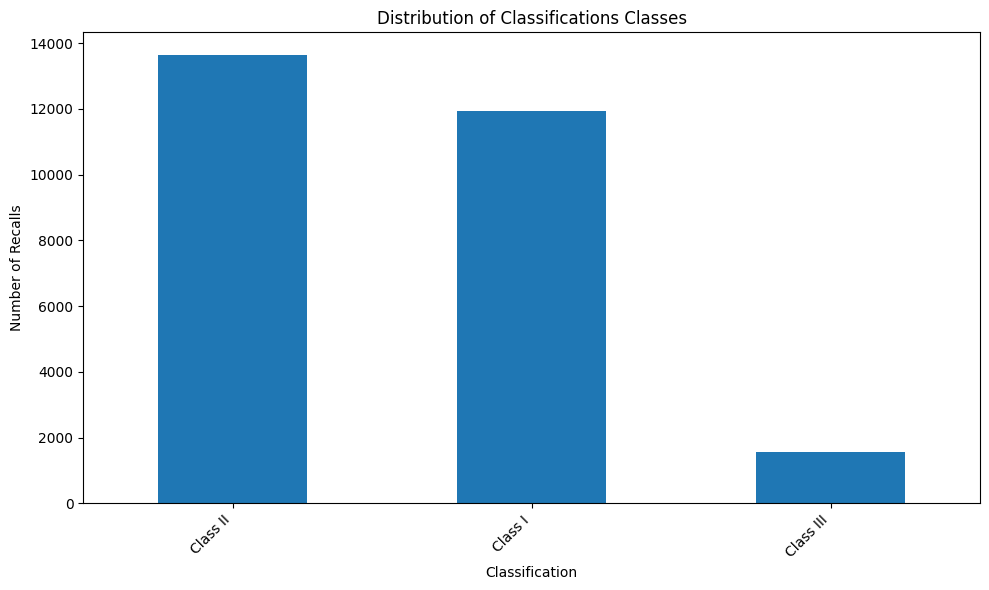

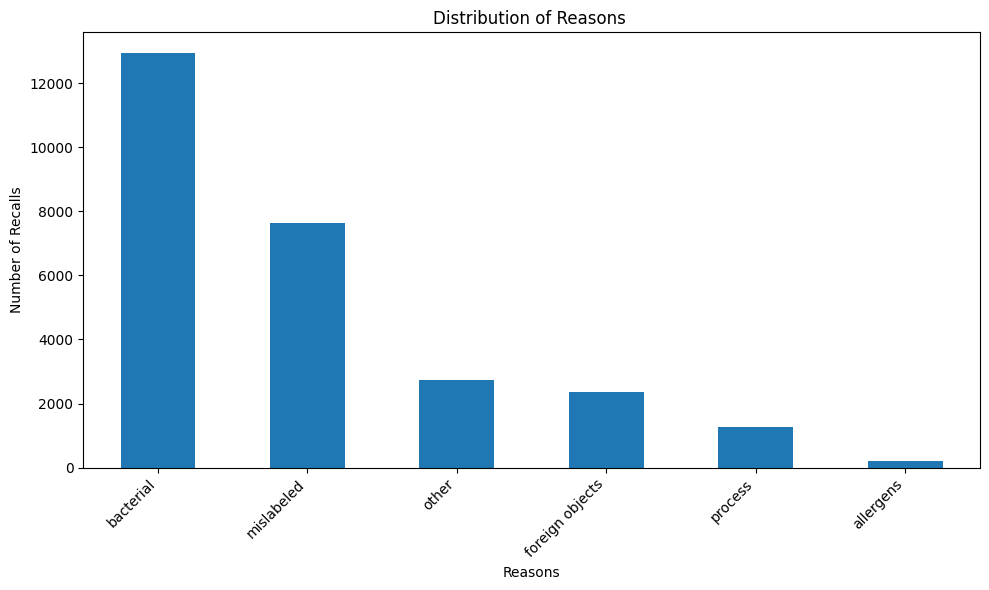

In [3]:

import matplotlib.pyplot as plt


# Create the histogram for Classification Classes
plt.figure(figsize=(10, 6))
df['classification'].value_counts().plot(kind='bar')
plt.title('Distribution of Classifications Classes')
plt.xlabel('Classification')
plt.ylabel('Number of Recalls')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Create the histogram for Reason
plt.figure(figsize=(10, 6))
df['reason'].value_counts().plot(kind='bar')
plt.title('Distribution of Reasons ')
plt.xlabel('Reasons')
plt.ylabel('Number of Recalls')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


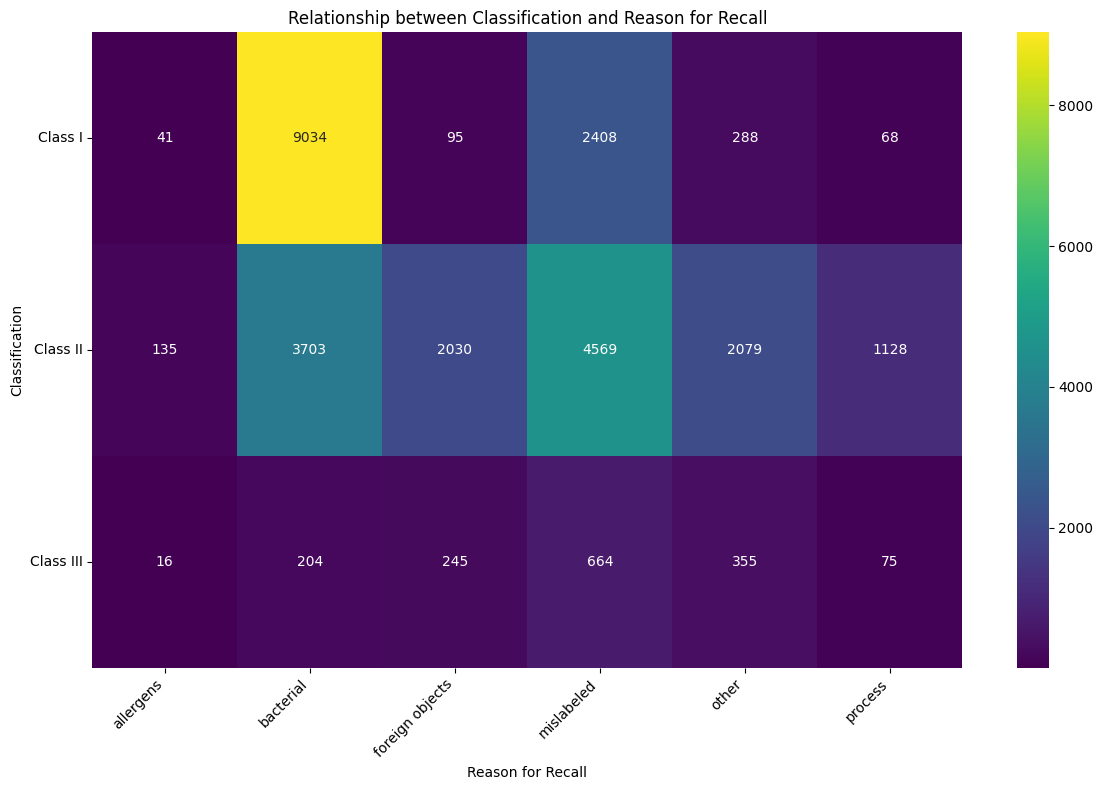

In [4]:
import seaborn as sns

# Create a cross-tabulation between 'classification' and 'reason'
classification_reason_counts = pd.crosstab(df['classification'], df['reason'])

# Plotting the cross-tabulation as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(classification_reason_counts, annot=True, fmt='d', cmap='viridis')
plt.title('Relationship between Classification and Reason for Recall')
plt.xlabel('Reason for Recall')
plt.ylabel('Classification')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


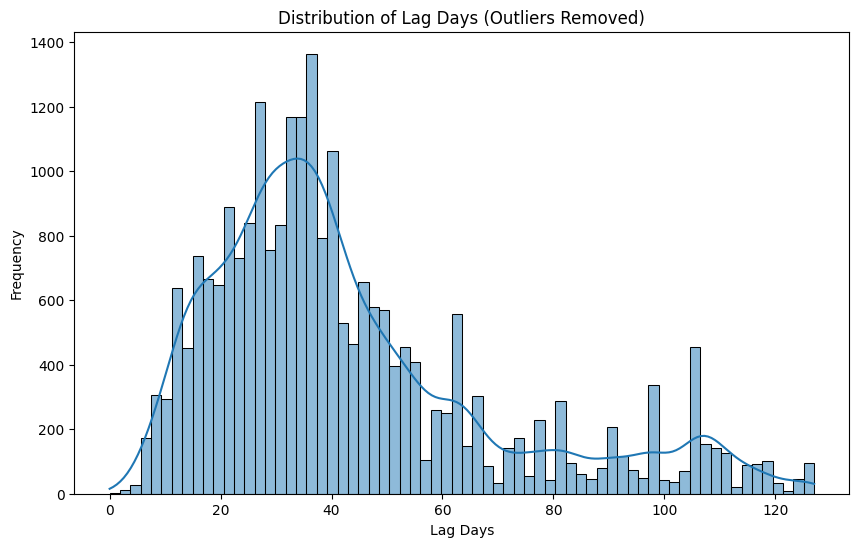

In [5]:


# Calculate the IQR for lag_days
Q1 = df['lag_days'].quantile(0.25)
Q3 = df['lag_days'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier removal
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_filtered = df[(df['lag_days'] >= lower_bound) & (df['lag_days'] <= upper_bound)]

# Create the lag days graph without outliers
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['lag_days'], kde=True)  # Use histplot for better visualization
plt.title('Distribution of Lag Days (Outliers Removed)')
plt.xlabel('Lag Days')
plt.ylabel('Frequency')
plt.show()


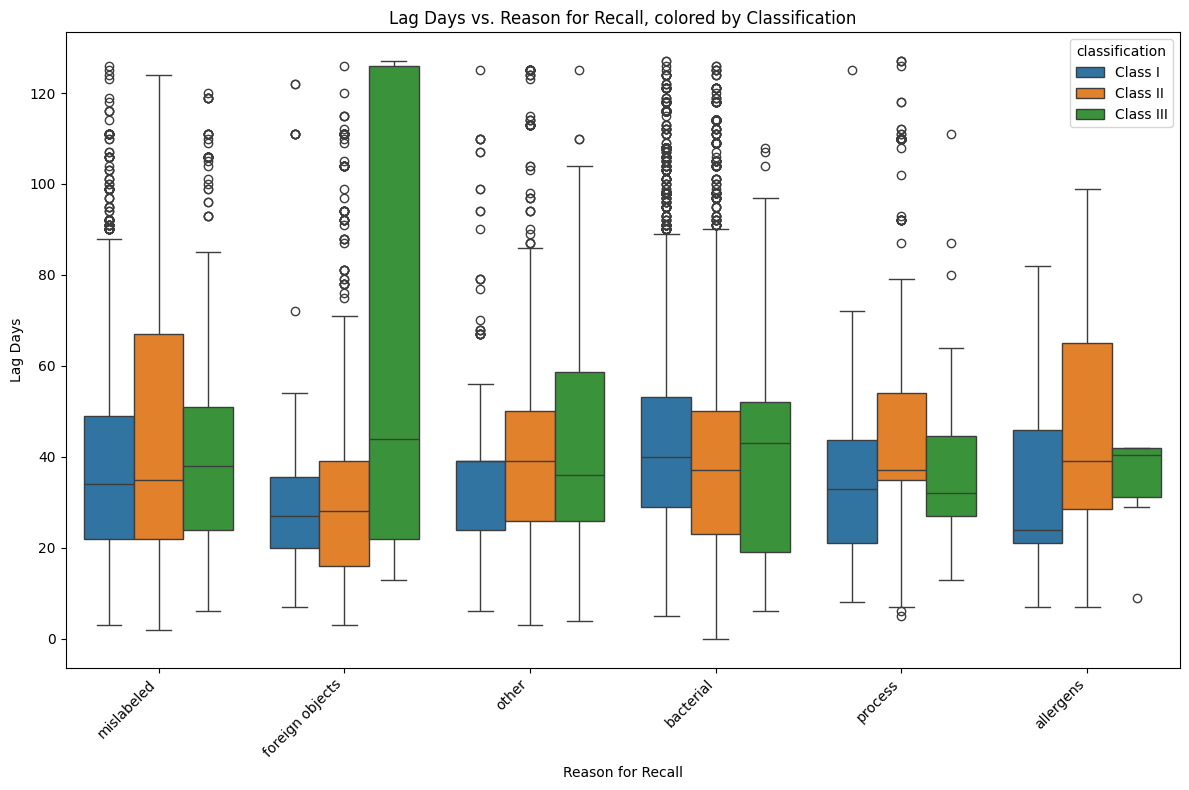

In [6]:

plt.figure(figsize=(12, 8))
sns.boxplot(x='reason', y='lag_days', hue='classification', data=df_filtered)
plt.title('Lag Days vs. Reason for Recall, colored by Classification')
plt.xlabel('Reason for Recall')
plt.ylabel('Lag Days')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


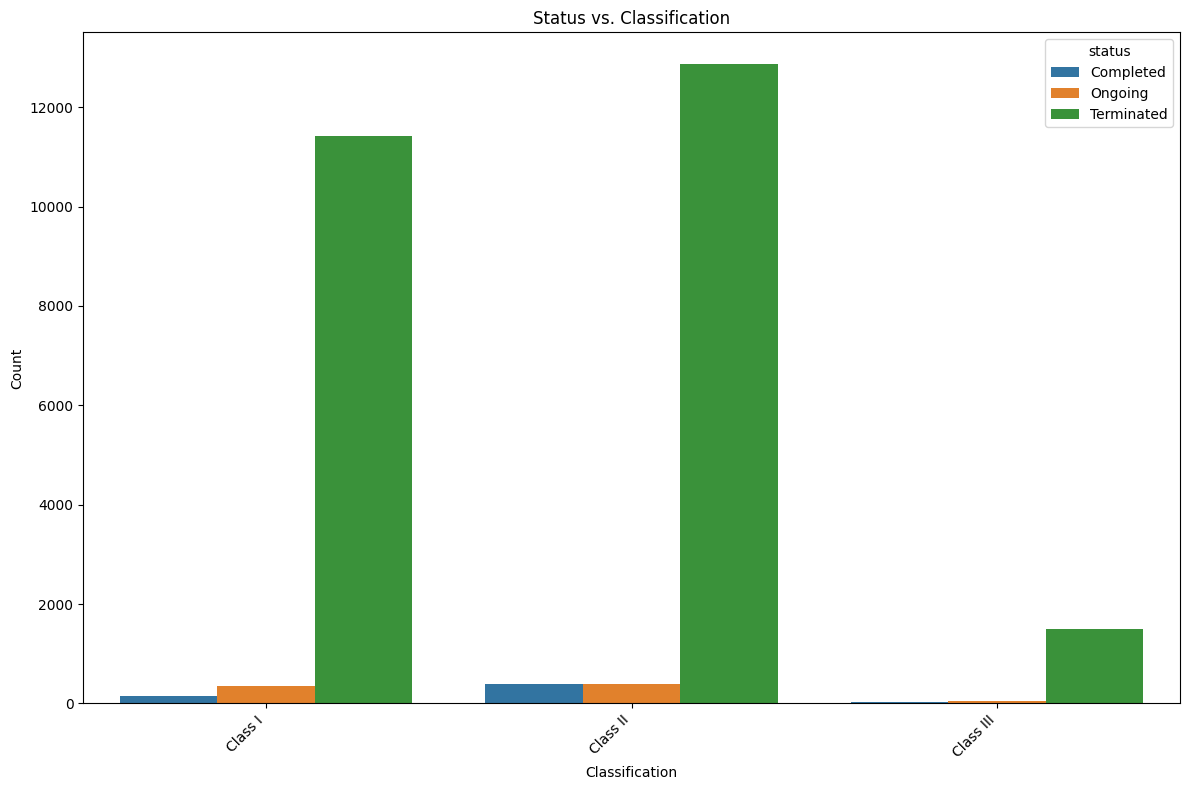

In [7]:

plt.figure(figsize=(12, 8))
sns.countplot(x='classification', hue='status', data=df)
plt.title('Status vs. Classification')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Accuracy: 0.815033161385409
              precision    recall  f1-score   support

     Class I       0.86      0.82      0.83      2401
    Class II       0.78      0.88      0.83      2718
   Class III       0.86      0.23      0.36       309

    accuracy                           0.82      5428
   macro avg       0.83      0.64      0.67      5428
weighted avg       0.82      0.82      0.81      5428



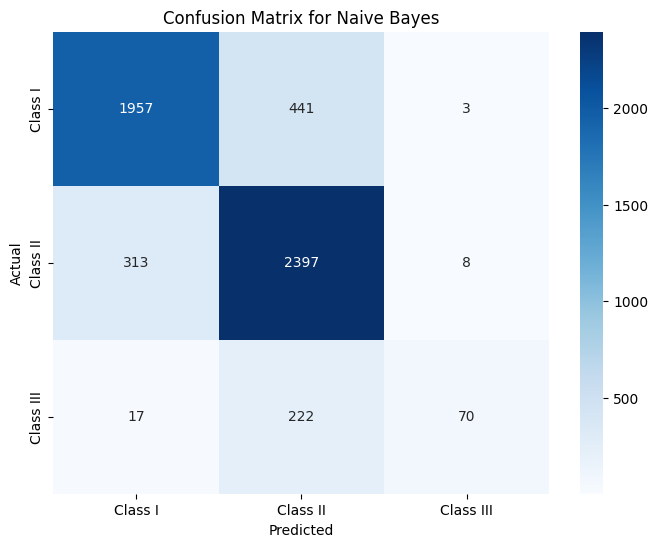

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert 'reason_for_recall' to string
df['reason_for_recall'] = df['reason_for_recall'].astype(str)

# Prepare the data for the Naive Bayes model
X = df['reason_for_recall']  # Read the reason for recall
y = df['classification']  # Use 'classification' as the target variable

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()




Naive Bayes Accuracy after GridSearchCV: 0.8334561532792926
Best Parameters for Naive Bayes: {'alpha': 0.1}
              precision    recall  f1-score   support

     Class I       0.86      0.82      0.84      2401
    Class II       0.82      0.87      0.84      2718
   Class III       0.74      0.58      0.65       309

    accuracy                           0.83      5428
   macro avg       0.81      0.76      0.78      5428
weighted avg       0.83      0.83      0.83      5428



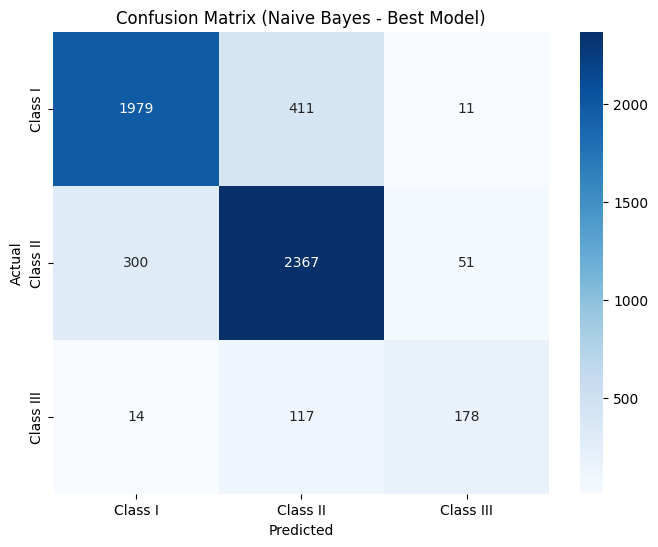

In [9]:
# Run Gridsearch CV on nb_classifier
from sklearn.model_selection import cross_val_score, GridSearchCV
# Define the parameter grid for Multinomial Naive Bayes
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]} # Example hyperparameter grid

# Create a GridSearchCV object
grid_nb = GridSearchCV(nb_classifier, param_grid_nb, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_nb.fit(X_train, y_train)

# Get the best estimator (model with the best hyperparameters)
best_nb_classifier = grid_nb.best_estimator_

# Make predictions using the best estimator
y_pred_nb = best_nb_classifier.predict(X_test)

# Evaluate the best model
accuracy_nb = accuracy_score(y_test, y_pred_nb)

print(f"\nNaive Bayes Accuracy after GridSearchCV: {accuracy_nb}")
print(f"Best Parameters for Naive Bayes: {grid_nb.best_params_}")
print(classification_report(y_test, y_pred_nb))

# Confusion Matrix for the best model
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_nb_classifier.classes_, yticklabels=best_nb_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Naive Bayes - Best Model)')
plt.show()


Logistic Regression Accuracy: 0.8848563006632277
Best Parameters for Logistic Regression: {'C': 10}
              precision    recall  f1-score   support

     Class I       0.88      0.90      0.89      2401
    Class II       0.89      0.89      0.89      2718
   Class III       0.86      0.71      0.78       309

    accuracy                           0.88      5428
   macro avg       0.88      0.83      0.85      5428
weighted avg       0.88      0.88      0.88      5428



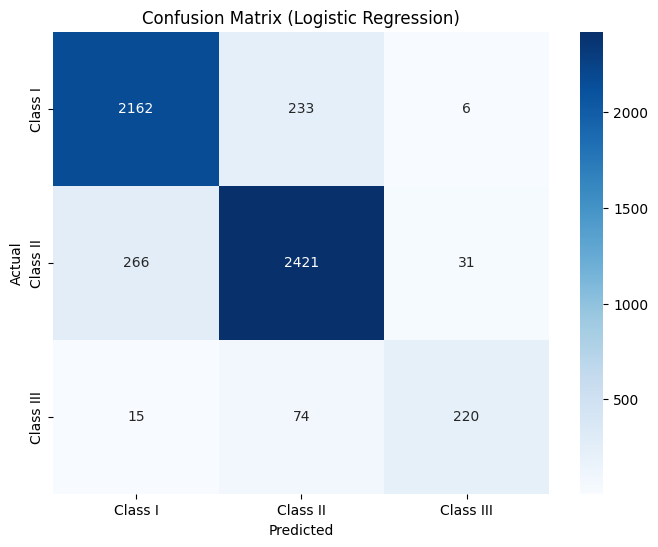

In [10]:


from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Logistic Regression model
logreg = LogisticRegression(max_iter=1000) # Increased max_iter
param_grid_logreg = {'C': [0.1, 1, 10]} # hyperparameter grid
grid_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, scoring='accuracy')
grid_logreg.fit(X_train, y_train)
y_pred_logreg = grid_logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

print(f"\nLogistic Regression Accuracy: {accuracy_logreg}")
print(f"Best Parameters for Logistic Regression: {grid_logreg.best_params_}")
print(classification_report(y_test, y_pred_logreg))

# Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=grid_logreg.classes_, yticklabels=grid_logreg.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()







Random Forest Accuracy: 0.909174649963154
Best Parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
              precision    recall  f1-score   support

     Class I       0.92      0.92      0.92      2401
    Class II       0.90      0.93      0.91      2718
   Class III       0.94      0.67      0.78       309

    accuracy                           0.91      5428
   macro avg       0.92      0.84      0.87      5428
weighted avg       0.91      0.91      0.91      5428



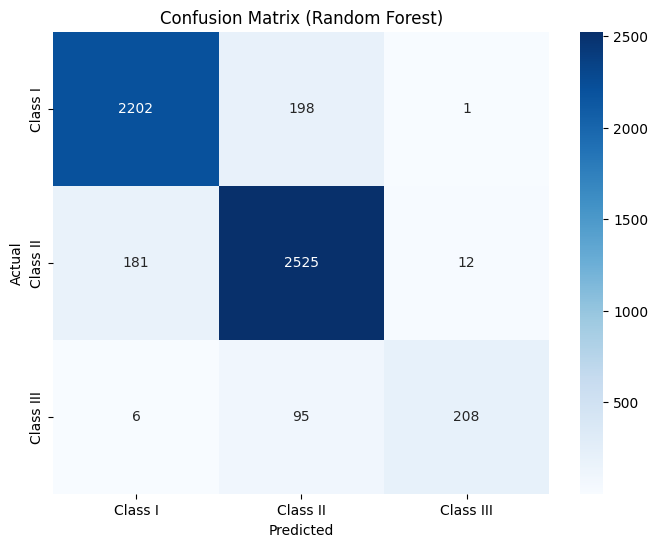

In [11]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\nRandom Forest Accuracy: {accuracy_rf}")
print(f"Best Parameters for Random Forest: {grid_rf.best_params_}")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=grid_rf.classes_, yticklabels=grid_rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()


Support Vector Machine Accuracy: 0.9119380987472365
Best Parameters for SVM: {'C': 10, 'kernel': 'rbf'}
              precision    recall  f1-score   support

     Class I       0.92      0.93      0.92      2401
    Class II       0.91      0.92      0.91      2718
   Class III       0.92      0.71      0.80       309

    accuracy                           0.91      5428
   macro avg       0.91      0.85      0.88      5428
weighted avg       0.91      0.91      0.91      5428



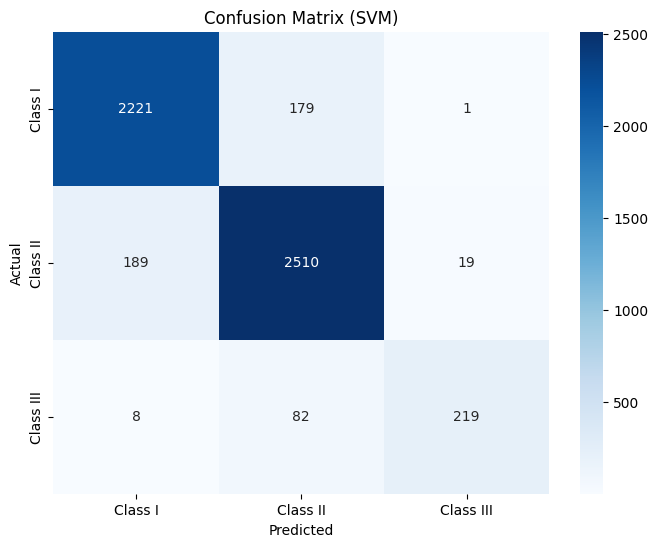

In [12]:
# Support Vector Machine
from sklearn.svm import SVC

svm = SVC(random_state=42)
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']} # hyperparameter grid
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train, y_train)
y_pred_svm = grid_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"\nSupport Vector Machine Accuracy: {accuracy_svm}")
print(f"Best Parameters for SVM: {grid_svm.best_params_}")
print(classification_report(y_test, y_pred_svm))


# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=grid_svm.classes_, yticklabels=grid_svm.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM)')
plt.show()


                  Model  precision    recall  f1-score  support
0           Naive Bayes   0.863061  0.824240  0.843204   2401.0
1           Naive Bayes   0.817617  0.870861  0.843399   2718.0
2           Naive Bayes   0.741667  0.576052  0.648452    309.0
3   Logistic Regression   0.884977  0.900458  0.892651   2401.0
4   Logistic Regression   0.887463  0.890728  0.889093   2718.0
5   Logistic Regression   0.856031  0.711974  0.777385    309.0
6         Random Forest   0.921725  0.917118  0.919415   2401.0
7         Random Forest   0.896026  0.928992  0.912211   2718.0
8         Random Forest   0.941176  0.673139  0.784906    309.0
9                   SVM   0.918528  0.925031  0.921768   2401.0
10                  SVM   0.905810  0.923473  0.914556   2718.0
11                  SVM   0.916318  0.708738  0.799270    309.0


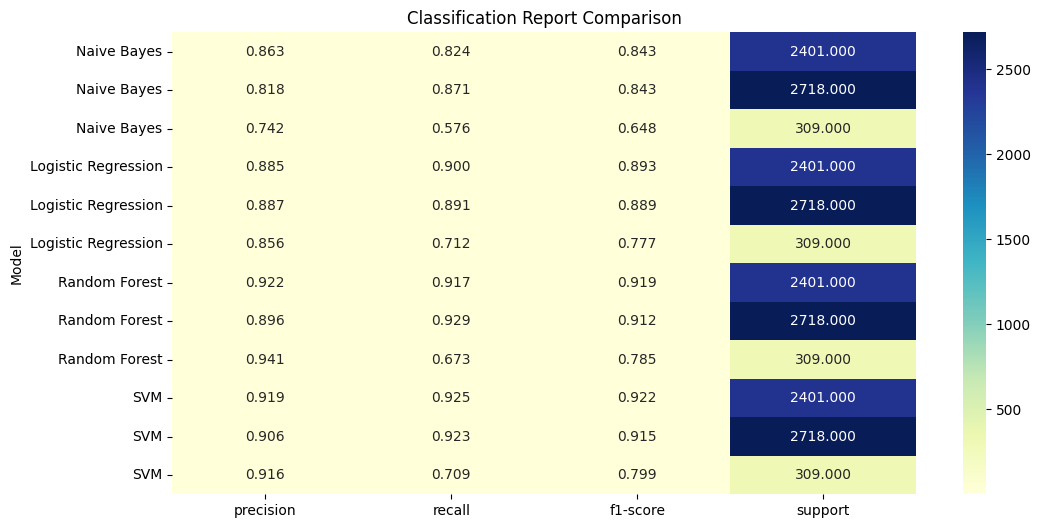

In [13]:

def create_classification_report_table(y_true, y_pred_nb, y_pred_logreg, y_pred_rf, y_pred_svm):
    report_nb = classification_report(y_true, y_pred_nb, output_dict=True)
    report_logreg = classification_report(y_true, y_pred_logreg, output_dict=True)
    report_rf = classification_report(y_true, y_pred_rf, output_dict=True)
    report_svm = classification_report(y_true, y_pred_svm, output_dict=True)

    reports = [report_nb, report_logreg, report_rf, report_svm]
    model_names = ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVM']

    # Extract metrics and create a DataFrame
    metrics = ['precision', 'recall', 'f1-score', 'support']
    classes = list(reports[0].keys())[:-3] # Exclude 'accuracy', 'macro avg', 'weighted avg'

    data = []
    for i, model in enumerate(model_names):
        for cls in classes:
            row = {'Model': model}
            for metric in metrics:
                row[metric] = reports[i][cls][metric]
            data.append(row)

    df_results = pd.DataFrame(data)
    return df_results


df_results = create_classification_report_table(y_test, y_pred_nb, y_pred_logreg, y_pred_rf, y_pred_svm)
print(df_results)

# Plotting the table as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_results.set_index('Model'), annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Classification Report Comparison')
plt.show()


In [14]:


def create_accuracy_table(accuracy_nb, accuracy_logreg, accuracy_rf, accuracy_svm):

    data = {
        'Model': ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVM'],
        'Accuracy': [accuracy_nb, accuracy_logreg, accuracy_rf, accuracy_svm]
    }
    df_accuracy = pd.DataFrame(data)
    return df_accuracy

accuracy_table = create_accuracy_table(accuracy_nb, accuracy_logreg, accuracy_rf, accuracy_svm)
accuracy_table


,Model,Accuracy
0,Naive Bayes,0.833456
1,Logistic Regression,0.884856
2,Random Forest,0.909175
3,SVM,0.911938


In [1]:
#  Boosting SVM with AdaBoost
from sklearn.ensemble import AdaBoostClassifier

svm_ada = SVC(probability=True, random_state=42)

# Define the parameter grid for AdaBoost
param_grid_ada = {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 1, 10]}

ada_svm = AdaBoostClassifier(svm_ada, random_state=42)
grid_svm_ada = GridSearchCV(ada_svm, param_grid_ada, cv=5, scoring='accuracy')
grid_svm_ada.fit(X_train, y_train)
y_pred_svm_ada = grid_svm_ada.predict(X_test)
accuracy_svm_ada = accuracy_score(y_test, y_pred_svm_ada)

print(f"\nBoosted Support Vector Machine Accuracy: {accuracy_svm_ada}")
print(f"Best Parameters for Boosted SVM: {grid_svm_ada.best_params_}")
print(classification_report(y_test, y_pred_svm_ada))


# Confusion Matrix for Boosted SVM
cm_svm_ada = confusion_matrix(y_test, y_pred_svm_ada)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_ada, annot=True, fmt='d', cmap='Blues',
            xticklabels=grid_svm_ada.classes_, yticklabels=grid_svm_ada.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Boosted SVM)')
plt.show()


# Update the classification report and accuracy table functions
def create_classification_report_table(y_true, y_pred_nb, y_pred_logreg, y_pred_rf, y_pred_svm, y_pred_svm_ada):
    reports = [report_nb, report_logreg, report_rf, report_svm, classification_report(y_true, y_pred_svm_ada, output_dict=True)]
    model_names = ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVM', 'Boosted SVM']

def create_accuracy_table(accuracy_nb, accuracy_logreg, accuracy_rf, accuracy_svm, accuracy_svm_ada):
    data = {
        'Model': ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVM', 'Boosted SVM'],
        'Accuracy': [accuracy_nb, accuracy_logreg, accuracy_rf, accuracy_svm, accuracy_svm_ada]
    }
    df_accuracy = pd.DataFrame(data)
    return df_accuracy

df_results = create_classification_report_table(y_test, y_pred_nb, y_pred_logreg, y_pred_rf, y_pred_svm, y_pred_svm_ada)
print(df_results)

plt.figure(figsize=(12, 6))
sns.heatmap(df_results.set_index('Model'), annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Classification Report Comparison')
plt.show()

accuracy_table = create_accuracy_table(accuracy_nb, accuracy_logreg, accuracy_rf, accuracy_svm, accuracy_svm_ada)
accuracy_table


NameError: name 'SVC' is not defined